# Fraud Prediction at Electronica 
## Part 1: Detailed Feature Engineering and Logistic Regression Algorithm


This outputs a machine learning model that predicts the probability 
that the first transaction of a new user is fraudulent.

If you fail to identify a fraudulent transaction, 
Electronica loses money equivalent to the price of the fraudulently purchased product. 

If you incorrectly flag a real transaction as fraudulent, 
it inconveniences the Electronica customers whose valid transactions are flagged—a cost your client values at $8.

    Created by Edwin Campos on 2020 Feb.16
    Last modification on 2020 Feb.18 by ecampos.phd@gmail.com


In [1]:
# Clean the memory
%reset -s

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# Dependencies
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Global Variables
INPUT_PATH = '/Users/ecampos/AnacondaProjects/DS-Fraud-Univar/Fraud - For Candidate/Fraud - For Candidate/'
INPUT_FILE = 'fraud.csv'
IP2COUNTRY_FILE = 'IpAddress_to_Country.csv'
TARGET = 'class'   # Column in dataframe with target values, Fraud:1, Good:0

In [4]:
# Ingest Input dataset
df_all=pd.read_csv(INPUT_PATH+INPUT_FILE, low_memory=False)

In [5]:
print(df_all.shape)
df_all.head()

(120000, 12)


,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,149671,285108,7/15/2015 4:36,9/10/2015 14:17,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0
1,15611,131009,1/24/2015 12:29,4/13/2015 4:53,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0
2,73178,328855,3/11/2015 0:54,4/5/2015 12:23,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0
3,84546,229053,1/7/2015 13:19,1/9/2015 10:12,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0
4,35978,108439,2/8/2015 21:11,4/9/2015 14:26,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0


## Feature Engeneering

### Do we have columns with too many missing values?

In [6]:
# Get rid of columns with too little values
print("% of missing observations:")
print(df_all.isnull().mean()*100)

% of missing observations:
Unnamed: 0        0.0
user_id           0.0
signup_time       0.0
purchase_time     0.0
purchase_value    0.0
device_id         0.0
source            0.0
browser           0.0
sex               0.0
age               0.0
ip_address        0.0
class             0.0
dtype: float64


Good! There are no missing values.

Otherwise we could have removed the columns with too many missing values, for example, ...
    
    DF = DF.drop('Match1Amt2',axis=1)
    
or we could have imputed the few missing values, by making these zero and creating a flag column, for example, ...
    
    columns2impute = dataframe.columns
    for col in columns2impute:
        DF[col+'_flag']=np.where(DF[col].isnull()==True,1,0)
        DF=DF.fillna(0)

### Are there repeated values for user_id?
If so, that would mean that we are getting transactions other than the first one, which we cannot use in the model.

Recall that we should only have information about each user’s first transaction on Electronica’s website.

In [7]:
# Select all duplicate rows based on one column
df_duplicate_user_id = df_all[df_all.duplicated(['user_id'])]
print("Duplicate Rows based on user_id column are:", df_duplicate_user_id, sep='\n')

Duplicate Rows based on user_id column are:
Empty DataFrame
Columns: [Unnamed: 0, user_id, signup_time, purchase_time, purchase_value, device_id, source, browser, sex, age, ip_address, class]
Index: []


Good! There are no duplicated user_id values.

Otherwise, we could simply remove the duplicates, for example, ...
  
    DF = DF.drop_duplicates()

### Handle Non-Numeric values

In [8]:
df_all.dtypes

Unnamed: 0          int64
user_id             int64
signup_time        object
purchase_time      object
purchase_value     object
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
dtype: object

#### Convert from Dates and Times into Seconds since Epoch

In [9]:
df_all['signup_datetime'] = pd.to_datetime(df_all['signup_time'])
df_all['signup_epoch'] = (df_all['signup_datetime'] - dt.datetime(1970,1,1)).dt.total_seconds()

In [10]:
df_all['purchase_datetime'] = pd.to_datetime(df_all['purchase_time'])
df_all['purchase_epoch'] = (df_all['purchase_datetime']  - dt.datetime(1970,1,1)).dt.total_seconds()

#### Create new column features for days of week and period between signup and first purchase

In [11]:
# days_name = {0:'Mon',1:'Tues',2:'Weds',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}
df_all['signup_dayofweek'] = df_all['signup_datetime'].dt.dayofweek
df_all['purchase_dayofweek'] = df_all['purchase_datetime'].dt.dayofweek
df_all["purchase_signup_epoch"] = (df_all['purchase_epoch'] - df_all['signup_epoch'])

In [12]:
# Unit test
df_t = pd.DataFrame({ 'my_dates':['2/16/2020 12:23','2/21/2020 4:36'] })
df_t['my_dates_datetime'] = pd.to_datetime(df_t['my_dates'])
df_t['dayofweek'] = df_t['my_dates_datetime'].dt.dayofweek
df_t['dayname'] = df_t['my_dates_datetime'].dt.weekday_name
print(df_t.head() )

          my_dates   my_dates_datetime  dayofweek dayname
0  2/16/2020 12:23 2020-02-16 12:23:00          6  Sunday
1   2/21/2020 4:36 2020-02-21 04:36:00          4  Friday


#### Convert columns purchase_value and age into numeric type

In [13]:
# Removing Non-Word Characters (% @ " ? % $) using Regular Expressions
# One can group multiple patterns to match or substitute in a string using the square bracket. 
df_all['purchase_value_numeric'] = df_all['purchase_value'].replace(r"[@\'?\$%_]", "", regex=True).apply(pd.to_numeric, errors='raise')

In [14]:
# Unit test
print('Input data: ', 
      df_all.purchase_value[586], 
      df_all.purchase_value[119999])
print('Output data: ',
      df_all.purchase_value_numeric[586], 
      df_all.purchase_value_numeric[119999])
print('Correct answer: 77  32')

if (df_all.purchase_value_numeric[586] == 77) and (df_all.purchase_value_numeric[119999] == 32):
    print('TEST PASSED!')
else:
    print('TEST FAILED!')

Input data:  $77  32
Output data:  77 32
Correct answer: 77  32
TEST PASSED!


#### Convert ip_address into country and then into classes (with one-hot-encoding)

In [15]:
# Ingest dataset with lookup table
df_ip2country = pd.read_csv(INPUT_PATH+IP2COUNTRY_FILE)

In [43]:
# Confirm that the data has been read properly, and does not have any missing values or undesired formats
print(df_ip2country.head())
print(df_ip2country.dtypes)
print(df_ip2country.isnull().mean()*100)

   lower_bound_ip_address  upper_bound_ip_address    country
0              16777216.0                16777471  Australia
1              16777472.0                16777727      China
2              16777728.0                16778239      China
3              16778240.0                16779263  Australia
4              16779264.0                16781311      China
lower_bound_ip_address    float64
upper_bound_ip_address      int64
country                    object
dtype: object
lower_bound_ip_address    0.0
upper_bound_ip_address    0.0
country                   0.0
dtype: float64


In [44]:
# Method to convert from ip address into country
def convert_ip2country(ip_number_df,lookup_df):
    """Outputs the country where the numeric IP Address is located.
    Call it as...
        convert_ip2country(df_all, df_ip2country)
    Inputs:
    ip_number_df -- Pandas Series with numeric values corresponding to an Internet Protocol address 
                    For example ips_df = pd.Series({'ip_address':[16777216,16777210.0]})
    lookup_df -- Pandas Dataframe name with information to map an IP address to its country
    """
    #Initialize output dataframe
    output_df = pd.DataFrame(columns=['ip_address'])
    
    for ip_number in ip_number_df['ip_address']:
        lookup_df_1 = lookup_df[ lookup_df['lower_bound_ip_address'] <= ip_number ]
        if lookup_df_1.empty:
            country = 'ErrorTooLowIP'
        else:
            lookup_df_2 = lookup_df_1[lookup_df_1['upper_bound_ip_address'] >= ip_number]
            if lookup_df_2.empty:
                country = 'ErrorTooHighIP'
            else:
                country = lookup_df_2['country'].iloc[0]
        output_df = output_df.append({'ip_address': country }, ignore_index=True)
    
    return output_df

In [45]:
# Unit test
df_2qry = pd.DataFrame({'lower_bound_ip_address': [1.0,10.0,20],
                        'upper_bound_ip_address': [9,19,29],
                        'country': ['USA', 'UK', 'Canada']
                       })

ips_df = pd.Series({'ip_address':[21, 11.0, 0.0, 31],
                    'class':[0,1,0,1,1]
                   })

output_df = convert_ip2country(ips_df,df_2qry)

if (output_df.ip_address.iloc[0] == 'Canada') and (output_df.ip_address.iloc[1] == 'UK'):
    print('TEST 1 PASSED! The countries are Canada and UK')
else:
    print('TEST 1 FAIL: The countries output were ', 
          output_df.ip_address.iloc[0],  ' and ',
          output_df.ip_address.iloc[1]
         )

ips_df = pd.Series({'ip_address':[0.0,31]})
if (output_df.ip_address.iloc[2] == 'ErrorTooLowIP') and (output_df.ip_address.iloc[3] == 'ErrorTooHighIP'):
    print('TEST 2 PASSED! The countries are ErrorTooLowIP and ErrorTooHighIP')
else:
    print('TEST 2 FAIL: The countries output were ', 
          output_df.ip_address.iloc[2], ' and ',
          output_df.ip_address.iloc[3]
         )

TEST 1 PASSED! The countries are Canada and UK
TEST 2 PASSED! The countries are ErrorTooLowIP and ErrorTooHighIP


In [42]:
# Create additional column with ip_country
df_all['ip_country'] = convert_ip2country(df_all, df_ip2country )

In [46]:
# Unit test, using values verified by Edwin
if (df_all.ip_country.iloc[0] == 'United States') and (df_all.ip_country.iloc[1] == 'United Kingdom'):
    print('TEST PASSED')
else:
    print('TEST FAILED!')

TEST PASSED


In [47]:
# Remove special characters from ip_country column
df_all['ip_country_clean'] = df_all['ip_country'].str.replace('\W', '')
print(df_all[['ip_country', 'ip_country_clean']])

                            ip_country          ip_country_clean
0                        United States              UnitedStates
1                       United Kingdom             UnitedKingdom
2                        United States              UnitedStates
3                    Korea Republic of           KoreaRepublicof
4                               Brazil                    Brazil
5                        United States              UnitedStates
6                       ErrorTooHighIP            ErrorTooHighIP
7                              Germany                   Germany
8                         South Africa               SouthAfrica
9                               France                    France
10                       United States              UnitedStates
11                       United States              UnitedStates
12                       United States              UnitedStates
13                               China                     China
14                       

#### Apply One-Hot-Encoding to columns ip_country, source, browser, and sex

In [48]:
# It's most common to one-hot encode these "object" columns, since they can't be plugged directly into most models. 
# Pandas offers a function called get_dummies to get one-hot encodings.
onehotencoding_columns = ['ip_country_clean','source', 'browser', 'sex']  # On column 'source', SEO corresponds to Search Engine Optimization
for col in onehotencoding_columns:
    df_dummies = pd.get_dummies(df_all[col], prefix = col)
    df_all = pd.concat([df_all, df_dummies], axis=1)

In [49]:
df_all.dtypes

Unnamed: 0                                      int64
user_id                                         int64
signup_time                                    object
purchase_time                                  object
purchase_value                                 object
device_id                                      object
source                                         object
browser                                        object
sex                                            object
age                                             int64
ip_address                                    float64
class                                           int64
signup_datetime                        datetime64[ns]
signup_epoch                                  float64
purchase_datetime                      datetime64[ns]
purchase_epoch                                float64
signup_dayofweek                                int64
purchase_dayofweek                              int64
purchase_signup_epoch       

#### Visualize Input Dataset

In [50]:
%matplotlib inline
sns.set(style='ticks')

In [51]:
# Pandas dataframe with numeric model features and model target
DF = pd.concat([df_all[['Unnamed: 0', 'user_id',
                         'age', 'ip_address', 
                         'signup_epoch', 'purchase_epoch', 
                         'signup_dayofweek', 'purchase_dayofweek', 
                         'purchase_signup_epoch', 'purchase_value_numeric',]], 
                df_all[[TARGET]]], axis=1)

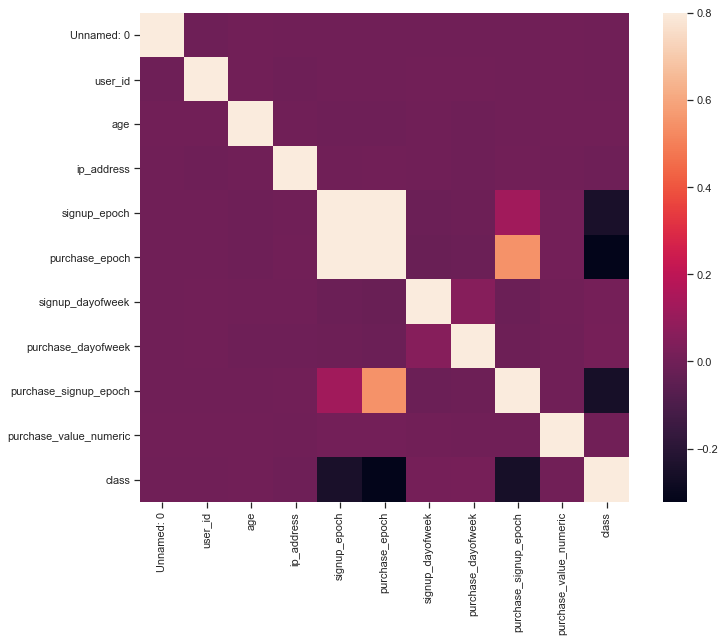

In [52]:
# Compute and visualize covariance (correlation) matrix
correl_matrix = DF.corr()
fig = plt.figure(figsize = (12,9))
sns.heatmap(correl_matrix, vmax=0.8, square=True)
plt.show()

Strong correlation between *signup_epoch* and *purchase_epoch*

    Eliminate one of these columns as a model feature!
    
Correlation near Zero between TARGET and *Unnamed: 0*, *user_id*, *age*, *ip_address*, 
*signup_dayofweek*, *purchase_dayofweek*, and *purchase_value_numeric*

    Eliminate only a couple of columns that seem irrelevant at moment of using the model

#### Identify features and target columns

In [53]:
unwanted_columns = ['signup_epoch',  # Redundant as per Covariance Matrix
                    'Unnamed: 0', 'user_id', 'device_id',  # irrelevant or random at moment of using model
                    'signup_time', 'purchase_time', 'purchase_value', #other numeric columns were created instead
                    'ip_country','ip_country_clean', # Other One-hot-encoded columns created instead
                    'source', 'browser', 'sex',  # Other One-hot-encoded columns created instead
                    'signup_datetime', 'purchase_datetime'  # Other numeric columns created instead
                   ]
unwanted_columns.append(TARGET)
feature_columns =[x for x in df_all.columns if x not in unwanted_columns]
X_train = df_all[feature_columns]
y_train = df_all[TARGET]
print('Model Features:', feature_columns)
print('Model Target:', TARGET)

Model Features: ['age', 'ip_address', 'purchase_epoch', 'signup_dayofweek', 'purchase_dayofweek', 'purchase_signup_epoch', 'purchase_value_numeric', 'ip_country_clean_Afghanistan', 'ip_country_clean_Albania', 'ip_country_clean_Algeria', 'ip_country_clean_Angola', 'ip_country_clean_AntiguaandBarbuda', 'ip_country_clean_Argentina', 'ip_country_clean_Armenia', 'ip_country_clean_Australia', 'ip_country_clean_Austria', 'ip_country_clean_Azerbaijan', 'ip_country_clean_Bahamas', 'ip_country_clean_Bahrain', 'ip_country_clean_Bangladesh', 'ip_country_clean_Barbados', 'ip_country_clean_Belarus', 'ip_country_clean_Belgium', 'ip_country_clean_Belize', 'ip_country_clean_Benin', 'ip_country_clean_Bermuda', 'ip_country_clean_Bhutan', 'ip_country_clean_Bolivia', 'ip_country_clean_BosniaandHerzegowina', 'ip_country_clean_Botswana', 'ip_country_clean_Brazil', 'ip_country_clean_BritishIndianOceanTerritory', 'ip_country_clean_BruneiDarussalam', 'ip_country_clean_Bulgaria', 'ip_country_clean_BurkinaFaso', 

In [54]:
print(X_train.shape)
X_train.describe()

(120000, 763)


,age,ip_address,purchase_epoch,signup_dayofweek,purchase_dayofweek,purchase_signup_epoch,purchase_value_numeric,ip_country_clean_Afghanistan,ip_country_clean_Afghanistan,ip_country_clean_Albania,...,browser_IE,browser_IE,browser_Opera,browser_Opera,browser_Safari,browser_Safari,sex_F,sex_F,sex_M,sex_M
count,120000.000000,1.200000e+05,1.200000e+05,120000.000000,120000.000000,1.200000e+05,120000.000000,120000.000000,120000.000000,120000.000000,...,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000
mean,33.125250,2.151550e+09,1.434431e+09,3.023633,3.016808,4.933112e+06,36.881475,0.000042,0.000042,0.000083,...,0.242817,0.242817,0.024792,0.024792,0.163500,0.163500,0.415617,0.415617,0.584383,0.584383
std,8.617081,1.248314e+09,7.040612e+06,2.006533,2.006733,3.127784e+06,18.325855,0.006455,0.006455,0.009128,...,0.428787,0.428787,0.155490,0.155490,0.369823,0.369823,0.492830,0.492830,0.492830,0.492830
min,18.000000,9.344714e+04,1.420070e+09,0.000000,0.000000,0.000000e+00,9.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,1.085345e+09,1.429372e+09,1.000000,1.000000,2.188140e+06,22.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,33.000000,2.155238e+09,1.434642e+09,3.000000,3.000000,4.924380e+06,34.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,39.000000,3.241268e+09,1.439840e+09,5.000000,5.000000,7.648215e+06,49.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,76.000000,4.294850e+09,1.450235e+09,6.000000,6.000000,1.036794e+07,154.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### How unbalanced is the target data?

In [55]:
def plot_balance(dataseries_name, plot_title, percent=True):
    """Generates a bar plot with the counts of frauds and no-frauds events.
    Arguments:
    dataseries_name: Pandas series with the target dataset 
                    For example 'ds'
    plot_title: For example 'Synthetic Unbalanced Dataset'
    percent: If False, will plot Counts. Default is True to display percents
    """
    if percent:
        percent_values = dataseries_name.value_counts(normalize=True).mul(100).round(1)
        sns.barplot([0,1], percent_values)
        y_label = 'Percent'
    else:
        sns.barplot([0,1], dataseries_name.value_counts().values)
        y_label = 'Count'
    plt.title(plot_title)
    plt.ylabel(y_label)
    plt.xlabel(TARGET+' (0:Good, 1:Fraud)')

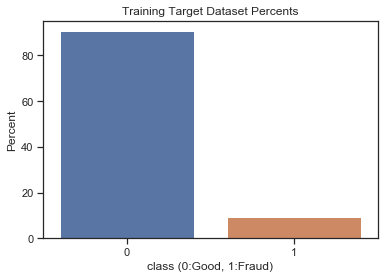

In [56]:
plot_balance(y_train, 'Training Target Dataset Percents')

In [57]:
# Show how unbalanced is the Target data
counts = y_train.value_counts()
perc = y_train.value_counts(normalize=True).mul(100).round(1)
pd.DataFrame({'counts': counts, 'percents': perc})

,counts,percents
0,108735,90.6
1,11265,9.4


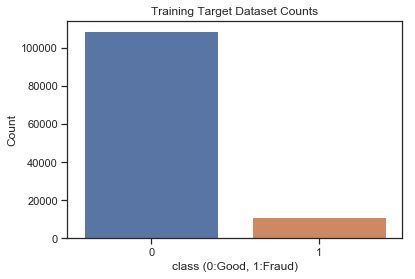

In [58]:
plot_balance(y_train, 'Training Target Dataset Counts', percent=False)

### Prove that the features can be used on a Machine Learning algorithm

#### Using Class-weighted Logistic Regression

Reference: https://machinelearningmastery.com/cost-sensitive-logistic-regression/

In [59]:
#import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

Estimating weights with my intuition:

In [60]:
weights = {0:9.0, 1:91.0}  # As best practice, use inverse of class distribution present in training dataset.
model_logistic_reg = LogisticRegression(solver='saga', 
                                        penalty='l1',   # Ridge regularization, to make some coefficients zero
                                        class_weight=weights)

In [61]:
model_logistic_reg.fit(X_train, y_train)

print('Weights:', weights)
print(classification_report(y_train, 
                            model_logistic_reg.predict(X_train)
                           ))

/Applications/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Weights: {0: 9.0, 1: 91.0}
              precision    recall  f1-score   support

           0       0.95      0.70      0.81    108735
           1       0.19      0.67      0.29     11265

   micro avg       0.70      0.70      0.70    120000
   macro avg       0.57      0.68      0.55    120000
weighted avg       0.88      0.70      0.76    120000



Estimating weights with sklearn method:

In [62]:
from sklearn.utils.class_weight import compute_class_weight
# calculate class weighting
weighting = compute_class_weight('balanced', [0,1], y_train)
print('compute_class_weight:', weighting)

weights = {0:weighting[0], 1:weighting[1]}
model_logistic_reg = LogisticRegression(solver='saga',  # For a faster solver, use 'saga' or 'sag' 
                                        penalty='l1',   # Ridge regularization, to make some coefficients zero
                                        class_weight=weights)

model_logistic_reg.fit(X_train, y_train)

print(classification_report(y_train, 
                            model_logistic_reg.predict(X_train)
                           ))

compute_class_weight: [0.55180025 5.32623169]


/Applications/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.95      0.64      0.77    108735
           1       0.17      0.70      0.27     11265

   micro avg       0.65      0.65      0.65    120000
   macro avg       0.56      0.67      0.52    120000
weighted avg       0.88      0.65      0.72    120000



The last two models seem to give similar performances, although the *later model* giver recall is a bit higher on class 1:Fraud.


Intermediaty step: In case we want to deploy a model without hyperparameter tuning, symply run 
    
    grid = model_logistic_reg.fit
..., then go to the last 2 cells of this notebook, and run these cells.

### Hyperparameter Tuning


##### What Metric should we optimize, Accuracy, Precision, Recall, F1, ROC, or other?

In [63]:
X_train['purchase_value_numeric'].describe()

count    120000.000000
mean         36.881475
std          18.325855
min           9.000000
25%          22.000000
50%          34.000000
75%          49.000000
max         154.000000
Name: purchase_value_numeric, dtype: float64

Considerations on the Cost Function to assess the model performance:

Note on False Negatives: If the model fails to identify a fraudulent transaction, 
Electronica loses money equivalent to the price of the fraudulently purchased product.

Note on False Positives: If the model incorrectly flags a real transaction as fraudulent, 
it inconveniences the Electronica customers whose valid transactions are flagged—a cost your client values at $8.

Since the mean product price is $36.88, from the above output, then False Negative errors cost over 4 times more than the False Positive errors.

    Thus, let's try a cost function that aims at reducing False Negatives

Recall in this context is also referred to as the true positive rate or sensitivity,

    Recall = true_positives / (true_positives + false_negatives)

Thus, we want the model that gives us the HIGHEST RECALL (for class1:Fraud) during Hyperparameter tuning.

However, as a final metric, we want a customized loss function...

In [64]:
from sklearn.metrics.scorer import make_scorer

def custom_loss(y_target, y_predict, X_input):
    """Calculates the average dollars lost per wrong prediction, for the Electronica Fraud model
    Call it as
        custom_loss( X_input=X_test, y_target=y_test, y_predict=y_pred_test )
    Inputs: 
        y_target -- True target values
        y_predict -- Target values predicted by the model
        X_input -- Model input-feature values
    Outputs:
        ratio = amount of dollars lost by model errors / number of predictions done by model
    """
    error= 0
    #for i in range(y_target.shape[0]):  # Use this for Pandas
    for i in range(len(y_target)):
        #False Negatives
        #if (y_predict.iloc[i].item() == 0) and (y_target.iloc[i].item() == 1):  # Use this for Pandas
        if (y_predict[i] == 0) and (y_target[i] == 1):                           # Use this for Numpy
            error_i = X_input.purchase_value_numeric.iloc[i]          
        #False Positives
        #elif y_predict.iloc[i].item() == 1 and y_target.iloc[i].item() == 0:    # Use this for Pandas
        elif y_predict[i] == 1 and y_target[i] == 0:     # Use this for Numpy
            error_i = 8
        else:
            error_i = 0
        error += error_i
    return error/len(y_target)

custom_scorer = make_scorer(custom_loss, greater_is_better=False)

In [69]:
# Unit test
import numpy as np
x_t = pd.DataFrame({'age':[20,30,40,50,60,70], 
                    'purchase_value_numeric':[20,30,40,50,60,2]
                   })
#y_ta = pd.DataFrame({'class':[0,1,0,1,1,0]})
y_ta = np.array([0,1,0,1,1,0])

#y_pr = pd.DataFrame({'class':[0,0,1,1,0,1]})
y_pr = np.array([0,0,1,1,0,1])
correct_error = 106.0/6.0
error = custom_loss(X_input=x_t, y_target=y_ta, y_predict=y_pr)
if round(error,2) == round(correct_error,2):  # equal when rounded to 2 decimal points
    print('TEST PASSED! Correct error equals ', correct_error)
else:
    print('TEST FAILED! Function gave error =', error)

TEST PASSED! Correct error equals  17.666666666666668


#### Grid Search with Recall

We will use repeated cross-validation to evaluate the model, with **3 repeats of 10-fold cross-validation**. 

The mode performance will be reported using the mean Recall averaged over repeats and all folds.

In [70]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Define model
# Using regularization penalty l1:Lasso:set_some_coeff_zero (l2:Ridge)
model_logistic_reg = LogisticRegression(penalty='l1') 

# define grid
balance = [{0:9.0, 1:91.0},
           {0:0.55180025,1:5.32623169},
           {0:100,1:1}, 
           {0:10,1:1}, 
           {0:1,1:1}, 
           {0:1,1:10}, 
           {0:1,1:100}]

param_grid = {'solver': ['liblinear','saga'],  # Algorithm used in optimization. liblinear is slower, saga is faster
              'C':[0.001,0.01,1.0,10.0],  # Inverse of regularization strength
               'class_weight': balance               # Weights associated with (unbalanced) target classes
              }
    
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define grid search to output final model
grid = GridSearchCV(estimator=model_logistic_reg, 
                    param_grid=param_grid, 
                    n_jobs=-1, # Number of jobs to run in parallel. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors.
                    cv=cv, scoring=make_scorer(recall_score))

# execute the grid search
grid_result = grid.fit(X_train, y_train)

# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("RECALL mean (stdev): %f (%f) - With: %r" % (mean, stdev, param))

In [ ]:
#Predict values based on new parameters
y_pred_final = grid.predict(X_train)

# New Model Evaluation metrics
print('Custom Lost Function: $' + str(custom_loss(X_input=X_train, 
                                                  y_target=y_train, 
                                                  y_predict=y_pred_final)) )
print('Accuracy Score : ' + str(accuracy_score(y_train,y_pred_final)))
print('Precision Score : ' + str(precision_score(y_train,y_pred_final)))
print('Recall Score : ' + str(recall_score(y_train,y_pred_final)))
print('F1 Score : ' + str(f1_score(y_train,y_pred_final)))

#Logistic Regression (Grid Search) Confusion matrix
confusion_matrix(y_train,y_pred_final)

# Final (Grid Search) Confusion Matrix on Training dataset
conf_matrix_train = confusion_matrix(y_train, y_pred_final)
print('Confusion Matrix:')
print(conf_matrix_train)

In [72]:
import itertools
def plot_confusion_matrix(cm, classes,
                          title='Confusion Matrix', 
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    print(cm)
    
    thresh = cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,int(round(cm[i,j])),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Plot Confusion Matrix in counts
plt.figure() 
plot_confusion_matrix(conf_matrix_train, classes=['0:Good','1:Fraud'], 
                      title="Train Confusion Matrix, Counts")
plt.figure()
#plt.show
plt.savefig('conf_matrix_counts_train.png')

# Plot Confusion Matrix in percents
conf_matrix_train_percents = 100.0 * conf_matrix_train /float(len(y_train))
plot_confusion_matrix(conf_matrix_train_percents, classes=['0:Good','1:Fraud'],
                      title="Train Confusion Matrix, Percents")
plt.show
plt.savefig('conf_matrix_prcnts_train.png')

This is not a good confusion matrix, because there are ZERO TRUE NEGATIVES.

Instead, let's try F_beta, because it takes into consideration both the Recall and Precision metrics.
F_beta gives the weighted harmonic mean of precision and recall), and one can use a beta that gives more weight on the Recall...
     
     by picking a beta Value in the interval 1 < Beta < +∞

    

#### Grid Search with F_beta

As Before, we will use repeated cross-validation to evaluate the model, with **3 repeats of 10-fold cross-validation**. 

The mode performance will be reported using the mean F_beta averaged over repeats and all folds.

In [73]:
from sklearn.metrics import fbeta_score
# Use is as... f2_scorer = make_scorer(fbeta_score, beta=2)

In [ ]:
# define model
model_logistic_reg = LogisticRegression(solver='saga',  # For a faster solver, use 'saga' or 'sag' 
                                        penalty='l1')   # Use 'l1' for Ridge regularization, to make some coefficients zero

# define grid
balance = [{0:9.0, 1:91.0},
           {0:0.55180025,1:5.32623169},
           {0:100,1:1}, 
           {0:10,1:1}, 
           {0:1,1:1}, 
           {0:1,1:10}, 
           {0:1,1:100}]
param_grid = dict(class_weight=balance)

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define grid search to output final model
grid = GridSearchCV(estimator=model_logistic_reg, 
                    param_grid=param_grid, 
                    n_jobs=-1, # Number of jobs to run in parallel. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors.
                    cv=cv, scoring=make_scorer(fbeta_score, beta=2))
                    
# execute the grid search
grid_result = grid.fit(X_train, y_train)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("F_2 mean (stdev): %f (%f) - With: %r" % (mean, stdev, param))

In [ ]:
#Predict values based on new parameters
y_pred_final = grid.predict(X_train)

# New Model Evaluation metrics  
print('Custom Lost Function: $' + str(custom_loss(X_input=X_train, 
                                                  y_target=y_train, 
                                                  y_predict=y_pred_final)) )
print('Accuracy Score : ' + str(accuracy_score(y_train,y_pred_final)))
print('Precision Score : ' + str(precision_score(y_train,y_pred_final)))
print('Recall Score : ' + str(recall_score(y_train,y_pred_final)))
print('F1 Score : ' + str(f1_score(y_train,y_pred_final)))

#Logistic Regression (Grid Search) Confusion matrix
confusion_matrix(y_train,y_pred_final)

# Final (Grid Search) Confusion Matrix on Training dataset
conf_matrix_train = confusion_matrix(y_train, y_pred_final)
print('Confusion Matrix:')
print(conf_matrix_train)

In [ ]:
# Plot Confusion Matrix in counts
plt.figure() 
plot_confusion_matrix(conf_matrix_train, classes=['0:Good','1:Fraud'], 
                      title="Train Confusion Matrix, Counts")
plt.figure()
#plt.show
plt.savefig('conf_matrix_counts_train.png')

# Plot Confusion Matrix in percents
conf_matrix_train_percents = 100.0 * conf_matrix_train /float(len(y_train))
plot_confusion_matrix(conf_matrix_train_percents, classes=['0:Good','1:Fraud'],
                      title="Train Confusion Matrix, Percents")
plt.show
plt.savefig('conf_matrix_prcnts_train.png')

This reduced the Custom Lost Function, but the False Positives are still too high, can we do it better?

#### Future Work -- Grid Search with Custom Lost Function

As Before, we will use repeated cross-validation to evaluate the model, with three repeats of 10-fold cross-validation. 

The mode performance will be reported using the mean Custom Lost Function averaged over repeats and all folds.

However, that scoring requires 3 input arguments instead of the 2 given on grid search, and that is giving the following error message:

    TypeError: custom_loss() missing 1 required positional argument: 'y_predict'
    
Thus, we will stay with the model optimized for the F2 metric as the final Logistic Regression model.

        # define model
        model_logistic_reg = LogisticRegression(solver='lbfgs')
        # define grid
        balance = [{0:9.0, 1:91.0},
                   {0:0.55180025,1:5.32623169},
                   {0:100,1:1}, 
                   {0:10,1:1}, 
                   {0:1,1:1}, 
                   {0:1,1:10}, 
                   {0:1,1:100}]
        param_grid = dict(class_weight=balance)

        # define evaluation procedure
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

        # define grid search to output final model
        grid = GridSearchCV(estimator=model_logistic_reg, 
                            param_grid=param_grid, 
                            n_jobs=-1, 
                            cv=cv, # y_target, y_predict, X_input
                            scoring=make_scorer(custom_loss, 
                                                y_target=y_train,
                                                X_input=X_train, 
                                                y_predict = ???,  # THIS REQUIRES THE PREDICTED VALUES [e.g., grid.fit(X_train, y_train)], WHICH I DON'T NOW YET HOW TO PASS IT
                                                greater_is_better=False) 
                           )

        # execute the grid search
        grid_result = grid.fit(X_train, y_train)

        # report the best configuration
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

        # report all configurations
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']
        for mean, stdev, param in zip(means, stds, params):
            print("CUSTOM LOST FUNCTION mean (stdev): %f (%f) - With: %r" % (mean, stdev, param))

### Deploy model

In [ ]:
#print(list(zip(grid.coef_, grid_features)))
print(X_train.shape, grid_result.best_estimator_.coef_.shape)

print(TARGET+' =')
for i in range(X_train.shape[1]):
    print( grid_result.best_estimator_.coef_[0][i],'*',X_train.columns[i] )
    if i != X_train.shape[1]:
        print('+')

In [ ]:
import pickle

pickle.dump(grid, open("fraud_model_logisticRegression.sav", 'wb'))

To deploy the model, later on, just run on Python the following...

    loaded_model = pickle.load(open(filename_model, 'rb'))
    result = loaded_model.score(X_test, y_test)
    print(result)